# replay figures

In [1]:
import sys
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
import seaborn as sns
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency 



Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 7,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

In [3]:
def cliffsDelta(lst1, lst2, **dull):

    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    lst1 = [x for x in lst1 if ~np.isnan(x)]  
    lst2 = [x for x in lst2 if ~np.isnan(x)]  

    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d, size

def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'


def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two

# load data and a features


In [12]:
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'

df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/replay/processed/replay_df.csv')

# add duration
df["ripple_duration"] = df.end_time - df.start_time
df = df[df.ripple_duration <= 0.5]

# add group
control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

df['group'] = np.ones_like(df.session)

regstr = '|'.join(control)
idx = df['session'].str.upper().str.contains(regstr)    
df.group[idx] = 'control'

regstr = '|'.join(pae)
idx = df['session'].str.upper().str.contains(regstr)    
df.group[idx] = 'pae'


print(df.keys())
df

Index(['Unnamed: 0', 'Var1', 'start_time', 'end_time', 'peak_time', 'session',
       'ep_type', 'bayesLinearWeighted', 'bayesRadon', 'slope_hpc',
       'pvalue_cellID_shuf', 'z_cellID_shuf', 'pvalue_circular_shuf',
       'z_circular_shuf', 'pvalue_column_cycle', 'z_column_cycle', 'nCells',
       'nSpks', 'start', 'stop', 'direction_used', 'traj_dist', 'traj_speed',
       'traj_step', 'replay_type', 'group', 'ripple_duration'],
      dtype='object')


<ipython-input-12-a4045152edd4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'control'
<ipython-input-12-a4045152edd4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'pae'


,Unnamed: 0,Var1,start_time,end_time,peak_time,session,ep_type,bayesLinearWeighted,bayesRadon,slope_hpc,...,nSpks,start,stop,direction_used,traj_dist,traj_speed,traj_step,replay_type,group,ripple_duration
0,0,0,64.0735,64.3115,64.2395,LEM3116_S20180715121821,track,-0.042963,0.043770,-2.246037,...,54,64.03,64.36,2,357.0,1081.818182,15.521739,reverse,control,0.238
1,1,1,69.6725,69.8375,69.7575,LEM3116_S20180715121821,track,-0.108782,0.033549,-4.704630,...,30,69.66,69.82,1,97.5,609.375000,8.125000,reverse,control,0.165
2,2,2,75.6455,75.7645,75.6905,LEM3116_S20180715121821,track,0.246464,0.045498,5.671282,...,31,75.67,75.74,1,90.0,1285.714286,12.857143,forward,control,0.119
3,3,3,76.6575,76.8485,76.7595,LEM3116_S20180715121821,track,-0.106657,0.030123,1.697663,...,36,76.67,76.84,1,207.0,1217.647059,15.923077,reverse,control,0.191
4,4,4,82.6075,82.6875,82.6445,LEM3116_S20180715121821,track,0.021064,0.033700,-1.510835,...,22,82.62,82.74,2,39.0,325.000000,4.875000,reverse,control,0.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,17557,52887,1462.5055,1462.7435,1462.5675,RH16_S20161207130000,track,0.049649,0.030754,2.246037,...,64,1462.49,1462.79,1,252.0,840.000000,12.000000,reverse,pae,0.238
17559,17559,52889,1474.8265,1475.0215,1474.9345,RH16_S20161207130000,track,0.011231,0.028768,2.538648,...,60,1474.78,1475.01,2,498.0,2165.217391,27.666667,reverse,pae,0.195
17560,17560,52890,1517.8245,1517.9705,1517.9195,RH16_S20161207130000,track,-0.023312,0.027545,1.920982,...,47,1517.79,1518.02,2,235.5,1023.913043,18.115385,reverse,pae,0.146
17561,17561,52891,1517.9795,1518.1955,1518.1035,RH16_S20161207130000,track,0.019614,0.028251,2.246037,...,67,1517.93,1518.25,2,414.0,1293.750000,20.700000,forward,pae,0.216


# explore replay trajectory features

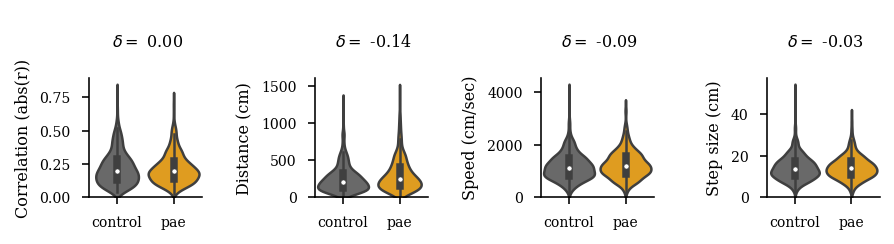

In [18]:
alpha = 0.05/2
# idx = (df.pvalue_cellID_shuf <= alpha) & (df.pvalue_circular_shuf <= alpha) & (df.pvalue_column_cycle <= alpha)
idx = (df.pvalue_circular_shuf <= alpha) & (df.pvalue_column_cycle <= alpha)

fig, axs = plt.subplots(1,4, figsize=set_size('thesis', fraction=1.2, subplots=(1, 4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()

# set params
x = 'group'
linewidth = 1.25
width = .9

# Create an array with the colors you want to use
colors = ['dimgrey','#ffa500ff']
# colors = ['dimgrey','gold']


# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# plot
axs[0] = sns.violinplot(x=x, y=np.abs(df.bayesLinearWeighted[idx]), data=df[idx],
               linewidth=linewidth,width=width,ax=axs[0])
axs[0].set_ylim(bottom=0)
axs[0].set_ylabel('Correlation (abs(r))')
d, size = cliffsDelta(np.abs(df.bayesLinearWeighted[idx & (df.group=="control")]), np.abs(df.bayesLinearWeighted[idx & (df.group=="pae")]))
axs[0].set_title("\n $\delta=$ {:0.2f}\n".format(d),fontsize=8)

axs[1] = sns.violinplot(x=x, y="traj_dist", data=df[idx],
               linewidth=linewidth,width=width,ax=axs[1])
axs[1].set_ylim(bottom=0)
axs[1].set_ylabel('Distance (cm)')
d, size = cliffsDelta(df.traj_dist[idx & (df.group=="control")], df.traj_dist[idx & (df.group=="pae")])
axs[1].set_title("\n $\delta=$ {:0.2f}\n".format(d),fontsize=8)


axs[2] = sns.violinplot(x=x, y="traj_speed", data=df[idx],
               linewidth=linewidth,width=width,ax=axs[2])
axs[2].set_ylim(bottom=0)
axs[2].set_ylabel('Speed (cm/sec)')
d, size = cliffsDelta(df.traj_speed[idx & (df.group=="control")], df.traj_speed[idx & (df.group=="pae")])
axs[2].set_title("\n $\delta=$ {:0.2f}\n".format(d),fontsize=8)


axs[3] = sns.violinplot(x=x, y="traj_step", data=df[idx],
               linewidth=linewidth,width=width,ax=axs[3])
axs[3].set_ylim(bottom=0)
axs[3].set_ylabel('Step size (cm)')

d, size = cliffsDelta(df.traj_step[idx & (df.group=="control")], df.traj_step[idx & (df.group=="pae")])
axs[3].set_title("\n $\delta=$ {:0.2f}\n".format(d),fontsize=8)

# clean up  box
for i in range(4):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].set_xlabel('')

# fig.text(0.5, -.3, 'Group', ha='center')
plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\replay_features.pdf',dpi=900,bbox_inches='tight')

Chi-squared test statistic without Yates correction (Scipy): 0.43351135706095345
P-value without Yates correction (Scipy): 0.5102709896648908
         forward  reverse  porp_forward  porp_reverse
control       75       53      0.585938      0.414062
pae          130       79      0.622010      0.377990


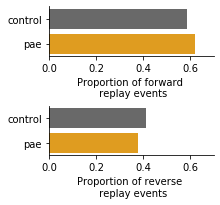

In [109]:
idx = df.pvalue_column_cycle <= 0.05

# df.replay_type == "forward"

num_forward_control = sum((df.replay_type == "forward") & (df.group == "control") & idx)
num_forward_pae = sum((df.replay_type == "forward") & (df.group == "pae") & idx)

num_reverse_control = sum((df.replay_type == "reverse") & (df.group == "control") & idx)
num_reverse_pae = sum((df.replay_type == "reverse") & (df.group == "pae") & idx)

ar = np.array([[num_forward_control,num_reverse_control],[num_forward_pae,num_reverse_pae]])
df_temp = pd.DataFrame(ar,columns = ["forward","reverse"])
df_temp.index = ["control","pae"]



tstat_scipy,pval_scipy,ddof_scipy,exp_scipy=chi2_contingency(df_temp, correction=False) # "correction=False" means no Yates' correction is used! 
print("Chi-squared test statistic without Yates correction (Scipy): " + str(tstat_scipy))
print("P-value without Yates correction (Scipy): " + str(pval_scipy))

sum_replay = df_temp.sum(axis=1)
df_temp['porp_forward'] = df_temp.forward / sum_replay
df_temp['porp_reverse'] = df_temp.reverse / sum_replay

print(df_temp)


fig, axs = plt.subplots(2,1, figsize=set_size('thesis', fraction=.5, subplots=(3, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.5)


# Create an array with the colors you want to use
colors = ['dimgrey','#ffa500ff']

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

ax = sns.barplot(x="porp_forward", y=df_temp.index, data=df_temp,ax=axs[0])
axs[0].set_xlabel('Proportion of forward \n replay events')
axs[0].set_xlim(0,0.7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

ax = sns.barplot(x="porp_reverse", y=df_temp.index, data=df_temp,ax=axs[1])
axs[1].set_xlabel('Proportion of reverse \n replay events')
axs[1].set_xlim(0,0.7)

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\forward_reverse_replay.pdf',dpi=900,bbox_inches='tight')

In [3]:
rip_n = 24

In [4]:
np.where(df.pvalue_cellID_shuf < 0.05)
# data = load([data_path,df.session{i},'.mat'],'Spikes','ratemap','frames','events')
session = data_path+df.iloc[rip_n].session+'.mat'
spikes = get_spikes(session)

In [13]:
np.where(df.pvalue_cellID_shuf < 0.05)
# data = load([data_path,df.session{i},'.mat'],'Spikes','ratemap','frames','events')
# session = 
# spikes = get_spikes(data_path+df.iloc[rip_n].session+'.mat')

In [5]:
# include = get_place_cell_idx(session)
ratemap = hdf5storage.loadmat(session,variable_names=['ratemap'])

In [ ]:
include = []
field = 0
for i in range(ratemap['ratemap'].shape[0]):
    for d in range(2):
        fields = get_place_fields(ratemap['ratemap'][i,d][0])
        if not fields.empty:
            field += 1
    if field > 0:
        include.append(1)
    else:
        include.append(0)
    field = 0


In [256]:
get_place_fields(ratemap['ratemap'][i,d][0])

In [192]:
curr_map = []
curr_maps = ratemap['ratemap'][:,df.direction_used[rip_n] - 1]
for i in range(len(curr_maps)):
    curr_map.append(curr_maps[i][0])
idx = np.argsort(np.argmax(curr_map, axis=1))
curr_map = np.array(curr_map)[idx]

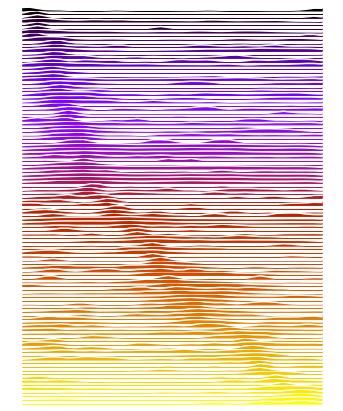

In [248]:
from matplotlib import cm
fig, axs = plt.subplots(len(curr_map),1, figsize=set_size('thesis', fraction=1, subplots=(2,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()
colors=cm.gnuplot(np.linspace(0,1,len(curr_map)))
x = np.arange(0,len(curr_map[i]))
for i in range(len(curr_map)):
    axs[i].plot(curr_map[i],color='white')
    axs[i].fill_between(x, curr_map[i], color=colors[i], alpha=1)

    axs[i].axis('off')

In [241]:
cmap(i / float(20))

(0.987053, 0.991438, 0.749504, 1.0)

In [22]:
pr_data = hdf5storage.loadmat(r'F:\Projects\PAE_PlaceCell\replay\processed\replay_Pr.mat')

In [35]:
map = pr_data['Pr'][rip_n]

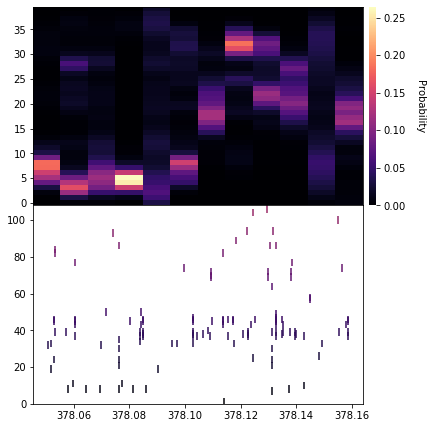

In [226]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axs = plt.subplots(2,1, figsize=set_size('thesis', fraction=1, subplots=(2,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()
cmap = plt.get_cmap('magma')
im = axs[0].imshow(map[0].transpose(),aspect='auto',cmap=cmap,origin='lower')

# set up parameters for colorbar
axins = inset_axes(axs[0],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=axs[0].transAxes,
                   borderpad=0,
                   )
# plot colorbar
cbar = fig.colorbar(im,ax=axs[0],cax=axins)
cbar.set_label('Probability', rotation=270, labelpad=20)
cbar.outline.set_visible(False)
    
current_spikes = []
for i in range(len(spikes)):
    current_spikes.append(spikes[i][(spikes[i] >= df.start[rip_n]) & (spikes[i] <= df.stop[rip_n])])
    
# reorder cells by perfered firing location    
current_spikes = [current_spikes[i] for i in idx]  

# plot raster
axs[1].eventplot(current_spikes,colors=color,linelengths=4)    
axs[1].set_ylim(0,len(current_spikes))
plt.show()